# Notes

1. Compare the different masks (DCT, unity, residual) to show the unbalanced masks can help in Dark Environment;  
2. The Poisson Noise only happens at the sensor;   
3. We can try on impractical masks (Not constrained in $\{0,1\}$) after we verified theory under binary masks;  
4. The unbalance mask is after mask constant, since we can make enviroment brighter and improve the SNR; 

Find the light level in this unbalanced mask;

## The question
To explain what is going on (as the figures showing the measurement)  

Find a figure representing the PMT(or point sensors) in those figures  

## Sensor properties  
Voxtel has 256 by 256 pixels (250 frams per second, 250 Hz)  
The PMT sensor has $10 \times 10 ^ 6$ Hz (10 mega Hz)  

In 1 second,  
Voxtel: $25$ photons for each pixel  
Raster scan: $10^6 / 256^2 = 15 $ photons for each pixel  

<b>pileup</b>  
number of photons never exceeds $10^6$ (10% of the max HZ)
number of photons in voxtel never exceeds $25$


In [1]:
import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation";
os.chdir(path);
os.listdir(path);

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


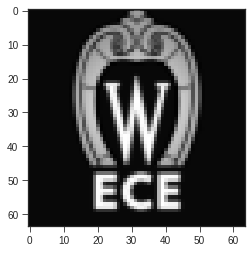

In [2]:
import numpy as np;
import matplotlib.pyplot as plt;
import matplotlib.image as mpimg;
plt.style.use(['seaborn-ticks'])
#plt.style.use(['classic'])

from PMT_compressed_sensing_simu import Compressed_sensing_PMT as CSP;
from YZ_masks import Haar_2d, Hyper_raster;

r = 64;
c = 64;

#########################################################
ratio_val = 0. ## to determine how many 1s in the masks!
Pnoise = True;
Gnoise = False;

Voxtel_camera = 25 * 256**2; ## the photon number per second for Vextel camera is 400
#########################################################

error = [];

pmt = CSP();
pmt.Load_img("ECE.jpg",RGB = False, size = (r,c), anti_aliasing = False);

In [3]:
pmt.img

array([[0.24783011, 0.24783011, 0.24783011, ..., 0.24783011, 0.24783011,
        0.24783011],
       [0.24783011, 0.24783011, 0.24783011, ..., 0.24783011, 0.24783011,
        0.24783011],
       [0.24783011, 0.24783011, 0.24783011, ..., 0.24783011, 0.24783011,
        0.24783011],
       ...,
       [0.24783011, 0.24783011, 0.24783011, ..., 0.24783011, 0.24783011,
        0.24783011],
       [0.24783011, 0.24783011, 0.24783011, ..., 0.24783011, 0.24783011,
        0.24783011],
       [0.24783011, 0.24783011, 0.24783011, ..., 0.24783011, 0.24783011,
        0.24783011]])

In [3]:
N_recons = 10000; ## the cycles to simulate the reconstruction

'''
r = 3;
c = 1;
pmt.img_tensor = np.array([[[1,3,5]]]).transpose(1,2,0);
'''

## test the SNR by a image with all the values are 1
#pmt.img_tensor = np.ones(pmt.img_tensor.shape)

recons_matrix = np.zeros((r*c,N_recons));

unity_basis = np.eye(r*c);
unity_inv = unity_basis;

residual_basis = np.ones((r*c,r*c)) - unity_basis;
residual_inv = np.linalg.pinv(residual_basis);

'''
masks = {};
masks["Unity"] = [unity_basis, unity_inv];
masks["Residual"] = [residual_basis, residual_inv]
'''

'\nmasks = {};\nmasks["Unity"] = [unity_basis, unity_inv];\nmasks["Residual"] = [residual_basis, residual_inv]\n'

In [4]:
#[DMD, DMD_inv] = masks["Residual"]

light_level = 1;
pmt.img_tensor = light_level * pmt.img_tensor;

N_recons = 100;
recons_matrix = np.zeros((r*c,N_recons));


## For unity basis first

DMD = unity_basis;
DMD_inv = unity_inv;
for i in range(N_recons):
    pmt.YZ_process_bar((i+1)/N_recons)
    measure = pmt.PMT_measure_simu(1, r*c, Poisson=True, upload_DMD_basis=DMD);
    pmt.PMT_direct_inverse_reconstruction(r,c,DMD_inv, measure, CS=False,display = False);
    recons_matrix[:,i] = pmt.img_reconstructed_vector.reshape((-1,));

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

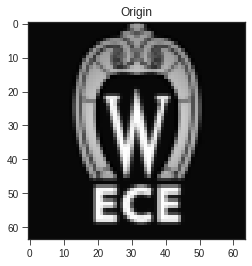

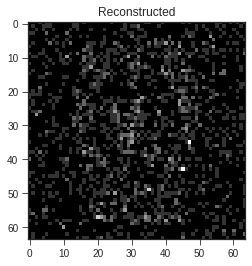

In [5]:
covar= np.cov(recons_matrix);

covar_unity = covar;

#plt.imshow(covar/np.max(np.abs(covar)), cmap = 'gray')

var_simu = np.diag(covar);
mean_simu = np.mean(recons_matrix, axis = 1);
SNR_simu = mean_simu/var_simu**0.5 ## SNR

SNR_unity_simu = SNR_simu;

plt.figure();
plt.imshow(pmt.img,cmap = 'gray');
plt.title('Origin');
plt.show();
plt.figure()
plt.imshow(pmt.img_reconstructed, cmap = 'gray');
plt.title('Reconstructed');
plt.show();

In [6]:
noiseless_measure = pmt.PMT_measure_simu(1, r*c, Poisson=False, upload_DMD_basis=DMD);
covar_noiseless = (DMD_inv.dot(np.diag(noiseless_measure.reshape((-1,))))).dot(DMD_inv.T);
SNR_theo = pmt.img_tensor[:,:,0].reshape(-1,)/np.diag(covar_noiseless)**0.5;

SNR_unity_theo = SNR_theo;

print("The theoretical SNR is\n",SNR_theo);
print("The simulated SNR is\n",SNR_simu);

print("The mean of theoretical SNR is\n",np.mean(SNR_theo));
print("The mean of simulated SNR is\n",np.mean(SNR_simu));

print("The mean bias between the theoretical and the simulated SNR is %.3e"%(np.mean((SNR_theo - SNR_simu)**2)**0.5));

The theoretical SNR is
 [0.49782538 0.49782538 0.49782538 ... 0.49782538 0.49782538 0.49782538]
The simulated SNR is
 [0.49286733 0.46617279 0.52982241 ... 0.53611506 0.48094533 0.49749372]
The mean of theoretical SNR is
 0.5955362205417656
The mean of simulated SNR is
 0.5980435529896111
The mean bias between the theoretical and the simulated SNR is 6.690e-02


---
Residual mask

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

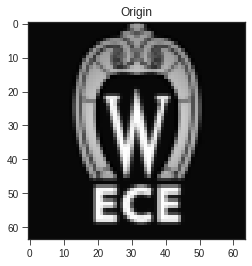

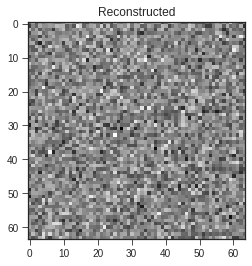

In [7]:
DMD = residual_basis;
DMD_inv = residual_inv;
for i in range(N_recons):
    pmt.YZ_process_bar((i+1)/N_recons)
    measure = pmt.PMT_measure_simu(1, r*c, Poisson=True, upload_DMD_basis=DMD);
    pmt.PMT_direct_inverse_reconstruction(r,c,DMD_inv, measure, CS=False,display = False);
    recons_matrix[:,i] = pmt.img_reconstructed_vector.reshape((-1,));

covar= np.cov(recons_matrix);

covar_residual = covar;

#plt.imshow(covar/np.max(np.abs(covar)), cmap = 'gray')

var_simu = np.diag(covar);
mean_simu = np.mean(recons_matrix, axis = 1);
SNR_simu = mean_simu/var_simu**0.5 ## SNR

SNR_residual_simu = SNR_simu;

plt.figure();
plt.imshow(pmt.img,cmap = 'gray');
plt.title('Origin');
plt.show();
plt.figure()
plt.imshow(pmt.img_reconstructed, cmap = 'gray');
plt.title('Reconstructed');
plt.show();


In [8]:
noiseless_measure = pmt.PMT_measure_simu(1, r*c, Poisson=False, upload_DMD_basis=DMD);
covar_noiseless = (DMD_inv.dot(np.diag(noiseless_measure.reshape((-1,))))).dot(DMD_inv.T);
SNR_theo = pmt.img_tensor[:,:,0].reshape(-1,)/np.diag(covar_noiseless)**0.5;

SNR_residual_theo = SNR_theo;

print("The theoretical SNR is\n",SNR_theo);
print("The simulated SNR is\n",SNR_simu);

print("The mean of theoretical SNR is\n",np.mean(SNR_theo));
print("The mean of simulated SNR is\n",np.mean(SNR_simu));

print("The mean bias between the theoretical and the simulated SNR is %.3e"%(np.mean((SNR_theo - SNR_simu)**2)**0.5));

The theoretical SNR is
 [0.00628962 0.00628962 0.00628962 ... 0.00628962 0.00628962 0.00628962]
The simulated SNR is
 [-0.05365266  0.07222359  0.00311146 ... -0.06523646 -0.13474749
 -0.11997351]
The mean of theoretical SNR is
 0.009624561698583944
The mean of simulated SNR is
 0.009667330888276046
The mean bias between the theoretical and the simulated SNR is 1.026e-01


In [9]:
np.diag(covar_unity) / np.diag(covar_residual) * (r*c)

array([0.75918283, 0.39742725, 0.59913327, ..., 0.9027902 , 0.68686689,
       0.36363263])

In [10]:
## Theory
def covar_derivation(measure, DMD_inv):
    return (DMD_inv.dot(np.diag(measure.reshape((-1,))))).dot(DMD_inv.T);